## **Construct: Identify and build an appropriate model**
Now, let us find out:
- Which models are most appropriate
- Construct that model 
- Confirm its model assumptions
- Evaluate model results to determine how well our model fits the data

## Recall model assumptions

**Logistic Regression model assumptions**
- Outcome variable is categorical
- Observations are independent of each other
- No severe multicollinearity among X variables 
- No extreme outliers
- Linear relationship between each X variable and the logit of the outcome variable
- Sufficiently large sample size 





### Identify the type of prediction task.

Our goal is to predict whether an employee leaves the company, which is a categorical outcome variable. So this task involves classification. More specifically, this involves binary classification, since the outcome variable `left` can be either 1 (indicating employee left) or 0 (indicating employee didn't leave). 

### Identify the types of models most appropriate for this task.

Since the variable we want to predict (whether an employee leaves the company) is categorical, we can build either a Logistic Regression model or a Tree-based Machine Learning model. 

We'll implement both, compare their performance, and choose the best one.

### Modeling Approach A: Logistic Regression Model

This approach covers implementation of Logistic Regression.

#### Logistic regression
Note that binomial logistic regression suits the task because it involves binary classification.

Before splitting the data, we need to encode the non-numeric variables. There are two: `department` and `salary`. 

`department` is a categorical variable, which means we can dummy it for modeling. 

`salary` is categorical too, but it's ordinal. There's a hierarchy to the categories, so it's better not to dummy this column, but rather to convert the levels to numbers, 0&ndash;2.

In [25]:
# Copy the dataframe
df_enc = df1.copy()

# Encode the `salary` column as an ordinal numeric category
df_enc['salary'] = (
    df_enc['salary'].astype('category')
    .cat.set_categories(['low', 'medium', 'high'])
    .cat.codes
)

# Dummy encode the `department` column
df_enc = pd.get_dummies(df_enc, drop_first=False)

# Display the new dataframe
df_enc.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


Now, we will create a heatmap to visualize how correlated variables are. Since there are 10 variables (columns), we will only consider the important variables.

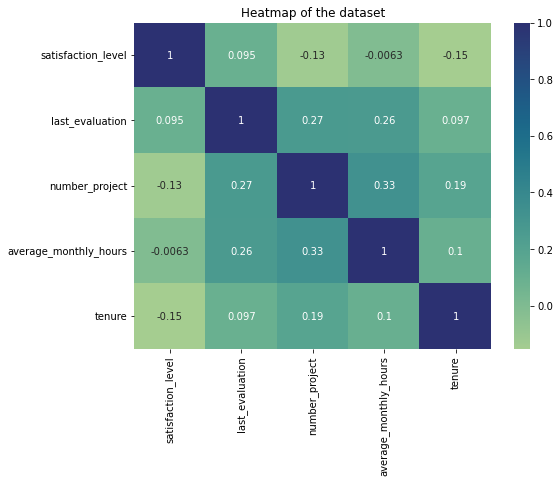

In [26]:
# Create a heatmap to visualize how correlated variables are
plt.figure(figsize=(8, 6))
sns.heatmap(df_enc[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure']]
            .corr(), annot=True, cmap="crest")
plt.title('Heatmap of the dataset')
plt.show()

We observed that the variables are not strongly correlated, with `number_project` and `avg_monthly_hrs` showing the highest correlation of 0.33, while others are much lower.

Now, we will create a stacked bart plot to visualize number of employees across department, comparing those who left with those who didn't.

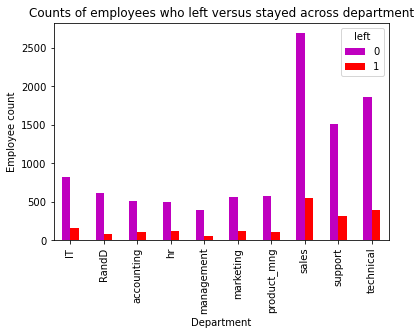

In [27]:
# Create a stacked bart plot to visualize number of employees across department, comparing those who left with those who didn't
# In the legend, 0 (purple color) represents employees who did not leave, 1 (red color) represents employees who left
pd.crosstab(df1['department'], df1['left']).plot(kind ='bar',color='mr')
plt.title('Counts of employees who left versus stayed across department')
plt.ylabel('Employee count')
plt.xlabel('Department')
plt.show()

**Since logistic regression is quite sensitive to outliers**, it would be a good idea at this stage to remove the outliers in the `tenure` column that were identified earlier.

In [28]:
# Select rows without outliers in `tenure` and save resulting dataframe in a new variable
df_logreg = df_enc[(df_enc['tenure'] >= lower_limit) & (df_enc['tenure'] <= upper_limit)]
# lower_limit and upper_limit are the varibles created in 1.Plan.ipynb notebook

# Display first few rows of new dataframe
df_logreg.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
5,0.41,0.50,2,153,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


Isolate the outcome variable, which is the variable you want your model to predict.

In [29]:
# Isolate the outcome variable
y = df_logreg['left']

# Display first few rows of the outcome variable
y.head() 

0    1
2    1
3    1
4    1
5    1
Name: left, dtype: int64

Select the features you want to use in your model. Consider which variables will help you predict the outcome variable, `left`.

In [30]:
# Select the features you want to use in your model
X = df_logreg.drop('left', axis=1)

# Display the first few rows of the selected features 
X.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,0,0,0,0,0,0,0,0,0,1,0,0
5,0.41,0.50,2,153,3,0,0,0,0,0,0,0,0,0,0,1,0,0


Split the data into training set and testing set. Don't forget to stratify based on the values in `y`, since the classes are unbalanced.

In [31]:
# Split the data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

Construct a logistic regression model and fit it to the training dataset.

In [32]:
# Construct a logistic regression model and fit it to the training dataset
log_clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)

Test the logistic regression model: use the model to make predictions on the test set.

In [33]:
# Use the logistic regression model to get predictions on the test set
y_pred = log_clf.predict(X_test)

Create a confusion matrix to visualize the results of the logistic regression model. 

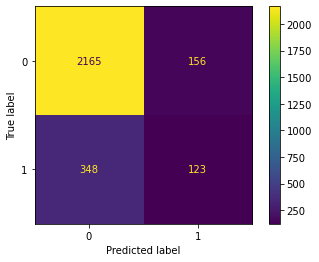

In [34]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, 
                                  display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot(values_format='')

# Display plot
plt.show()

The upper-left quadrant displays the number of true negatives.
The upper-right quadrant displays the number of false positives.
The bottom-left quadrant displays the number of false negatives.
The bottom-right quadrant displays the number of true positives.

True negatives: The number of people who did not leave that the model accurately predicted did not leave.

False positives: The number of people who did not leave the model inaccurately predicted as leaving.

False negatives: The number of people who left that the model inaccurately predicted did not leave

True positives: The number of people who left the model accurately predicted as leaving

A perfect model would yield all true negatives and true positives, and no false negatives or false positives.

Create a classification report that includes precision, recall, f1-score, and accuracy metrics to evaluate the performance of the logistic regression model.

Check the class balance in the data. In other words, check the value counts in the `left` column. Since this is a binary classification task, the class balance informs the way you interpret accuracy metrics.

In [35]:
df_logreg['left'].value_counts(normalize=True)

0    0.831468
1    0.168532
Name: left, dtype: float64

There is an approximately 83%-17% split. So the data is not perfectly balanced, but it is not too imbalanced. If it was more severely imbalanced, we might have to resample the data to make it more balanced. In this case, we can use this data without modifying the class balance and continue evaluating the model.

In [36]:
# Create classification report for logistic regression model
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.93      0.90      2321
    Predicted would leave       0.44      0.26      0.33       471

                 accuracy                           0.82      2792
                macro avg       0.65      0.60      0.61      2792
             weighted avg       0.79      0.82      0.80      2792



The classification report above shows that the logistic regression model achieved a precision of 79%, recall of 82%, f1-score of 80% (all weighted averages), and accuracy of 82%. 

**However, if it's most important to predict employees who leave, then the scores are significantly lower.**

### Modeling Approach B: Tree-based Model
This approach covers implementation of Decision Tree and Random Forest. 

Isolate the outcome variable.

In [37]:
# Isolate the outcome variable
y = df_enc['left']

# Display the first few rows of `y`
y.head()

0    1
1    1
2    1
3    1
4    1
Name: left, dtype: int64

Select the features. 

In [38]:
# Select the features
X = df_enc.drop('left', axis=1)

# Display the first few rows of `X`
X.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,0,0,0,0,0,0,0,0,0,1,0,0


Split the data into training, validating, and testing sets.

In [39]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

#### Decision tree - Round 1

Construct a decision tree model and set up cross-validated grid-search to exhuastively search for the best model parameters.

In [40]:
# Instantiate model
tree = DecisionTreeClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
tree1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

Fit the decision tree model to the training data.

In [41]:
%%time
tree1.fit(X_train, y_train)

CPU times: user 2.7 s, sys: 91 ms, total: 2.79 s
Wall time: 2.8 s


GridSearchCV(cv=4, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                

Identify the optimal values for the decision tree parameters.

In [42]:
# Check best parameters
tree1.best_params_

{'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2}

Identify the best AUC score achieved by the decision tree model on the training set.

In [43]:
# Check best AUC score on CV
tree1.best_score_

0.969819392792457

This is a strong AUC score, which shows that this model can predict employees who will leave very well.

Next, we can write a function that will help us extract all the scores from the grid search. 

In [44]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what we want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, accuracy, or auc
  
    Returns a pandas df with the F1, recall, precision, accuracy, and auc scores
    for the model with the best mean 'metric' score across all validation folds.  
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })
  
    return table

Use the function just defined to get all the scores from grid search.

In [45]:
# Get all CV scores
tree1_cv_results = make_results('decision tree cv', tree1, 'auc')
tree1_cv_results

,model,precision,recall,F1,accuracy,auc
0,decision tree cv,0.914552,0.916949,0.915707,0.971978,0.969819


All of these scores from the decision tree model are strong indicators of good model performance. 

Recall that **decision trees can be vulnerable to overfitting, and random forests avoid overfitting by incorporating multiple trees to make predictions**. 
So, we can construct a random forest model now.

#### Random forest - Round 1

Construct a random forest model and set up cross-validated grid-search to exhuastively search for the best model parameters.

In [46]:
# Instantiate model
rf = RandomForestClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

Fit the random forest model to the training data.

In [47]:
%%time
rf1.fit(X_train, y_train) # --> Wall time: ~10min

CPU times: user 9min 7s, sys: 3.01 s, total: 9min 10s
Wall time: 9min 10s


GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,...
                                              verbose=0, warm_start=False),
             iid='deprecated', n_jo

Identify the best AUC score achieved by the random forest model on the training set.

In [53]:
# Check best AUC score on CV
rf1.best_score_

0.9804250949807172

Identify the optimal values for the parameters of the random forest model.

In [54]:
# Check best params
rf1.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 500}

Collect the evaluation scores on the training set for the decision tree and random forest models.

In [55]:
# Get all CV scores
rf1_cv_results = make_results('random forest cv', rf1, 'auc')
print(tree1_cv_results)
print(rf1_cv_results)

              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.914552  0.916949  0.915707  0.971978  0.969819
              model  precision    recall        F1  accuracy       auc
0  random forest cv   0.950023  0.915614  0.932467  0.977983  0.980425


The evaluation scores of the random forest model are better than those of the decision tree model, with the exception of recall (the recall score of the random forest model is approximately 0.001 lower, which is a negligible amount). This indicates that the random forest model mostly outperforms the decision tree model.

Next, we can evaluate the final model on the test set.

Define a function that gets all the scores from a model's predictions.

In [56]:
def get_scores(model_name:str, model, X_test_data, y_test_data):
    '''
    Generate a table of test scores.

    In: 
        model_name (string):  How you want your model to be named in the output table
        model:                A fit GridSearchCV object
        X_test_data:          numpy array of X_test data
        y_test_data:          numpy array of y_test data

    Out: pandas df of precision, recall, f1, accuracy, and AUC scores for your model
    '''

    preds = model.best_estimator_.predict(X_test_data)

    auc = roc_auc_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision], 
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy],
                          'AUC': [auc]
                         })
  
    return table

Now use the best performing model to predict on the test set.

In [57]:
# Get predictions on test data
rf1_test_scores = get_scores('random forest1 test', rf1, X_test, y_test)
rf1_test_scores

,model,precision,recall,f1,accuracy,AUC
0,random forest1 test,0.964211,0.919679,0.941418,0.980987,0.956439


The test scores are very similar to the validation scores, which is good. This appears to be a strong model. Since this test set was only used for this model, you can be more confident that your model's performance on this data is representative of how it will perform on new, unseeen data.